In this task, i'll be building a classification model to predict building damage for the district of Kavrepalanchok(district_id=3), which has the most observations in the id_map table.

In [1]:
# Import Libraries
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Connect

In [2]:
# Connect to the nepal earthquake database
%load_ext sql
%sql sqlite:////home/linuxdavid/Machine_Learning_Specialization/WQU/EarthQuake/nepal.sqlite


In [5]:
%%sql
-- Calculate the number of observations in the id_map table associated with district 3.
SELECT count(*)
FROM id_map
WHERE district_id = 3

 * sqlite:////home/linuxdavid/Machine_Learning_Specialization/WQU/EarthQuake/nepal.sqlite
Done.


count(*)
82684


Next I will join the unique building IDs from Kavrepalanchok in id_map, all the columns from building_structure, and the damage_grade column from building_damage.

In [6]:
%%sql
SELECT distinct(i.building_id) AS b_id,   
     s.*,     
     d.damage_grade   
FROM id_map AS i
JOIN building_structure AS s ON i.building_id = s.building_id
JOIN building_damage AS d ON i.building_id = d.building_id
WHERE district_id = 3
LIMIT 5

 * sqlite:////home/linuxdavid/Machine_Learning_Specialization/WQU/EarthQuake/nepal.sqlite
Done.


b_id,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,damage_grade
87473,87473,2,1,15,382,18,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 4
87479,87479,1,0,12,328,7,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5
87482,87482,2,1,23,427,20,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
87491,87491,2,1,12,427,14,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
87496,87496,2,0,32,360,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5


Now I can use the wrangling function from the wrangling notebook create a dataframe from the query and clean it.

In [7]:
# Import
def wrangle(db_path):
    # Connect to database using connect method
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 3
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")

    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    # Create binary target
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)    # encode as 0's and 1's
    
    # Drop old target
    drop_cols.append("damage_grade")
    
    # Drop multicolinearity column
    drop_cols.append("count_floors_pre_eq")
    
    # Drop high categorical features
    drop_cols.append("building_id")
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)
    
    return df

In [8]:
df = wrangle("/home/linuxdavid/Machine_Learning_Specialization/WQU/EarthQuake/nepal.sqlite")

df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
87473,15,382,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87479,12,328,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar",1
87482,23,427,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87491,12,427,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87496,32,360,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1


# Explore


Are the classes in this dataset balanced? 

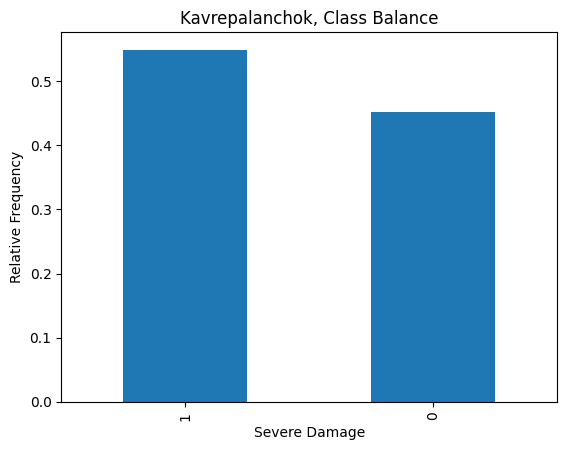

In [10]:
# Create a bar chart with the normalized value counts from the "severe_damage" column.
# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Severe Damage", ylabel="Relative Frequency", title="Kavrepalanchok, Class Balance"
);

The majority class here is the severely damaged buildings with over 55% and the minority class are the not severely damaged buildings representing about 45% of the data.

Is there a relationship between the footprint size of a building and the damage it sustained in the earthquake?

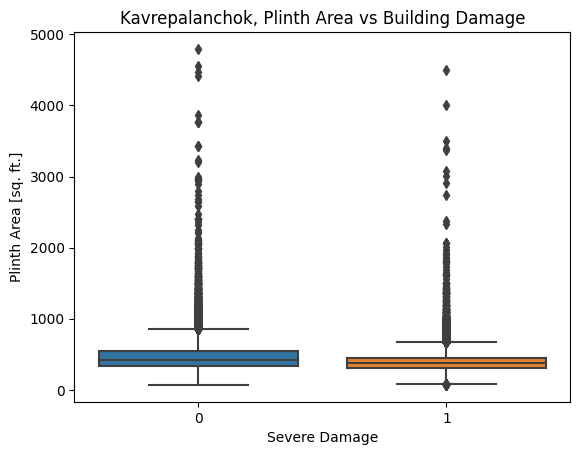

In [13]:
# Use seaborn to create a boxplot that shows the distributions of the "plinth_area_sq_ft" column for both groups in the "severe_damage" column.
sns.boxplot(x="severe_damage", y="plinth_area_sq_ft", data=df)
# Label axes
plt.xlabel('Severe Damage')
plt.ylabel("Plinth Area [sq. ft.]")
plt.title("Kavrepalanchok, Plinth Area vs Building Damage");

Are buildings with certain roof types more likely to suffer severe damage?

In [14]:
# Create a pivot table of df where the index is "roof_type" and 
# the values come from the "severe_damage" column, aggregated by the mean.

roof_pivot = pd.pivot_table(
    df, index="roof_type", values="severe_damage", aggfunc=np.mean
).sort_values(by="severe_damage")

roof_pivot

,severe_damage
roof_type,
RCC/RB/RBC,0.040715
Bamboo/Timber-Heavy roof,0.569477
Bamboo/Timber-Light roof,0.604842


The pivot table shows that buildings with bamboo/timber roofs are more likely to be severely damaged in the event of an earthquake.

# Split

In [32]:
# Create your feature matrix X and target vector y
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (76533, 11)
y shape: (76533,)


In [34]:
# Divide the data into training and validation sets using a randomized split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (61226, 11)
y_train shape: (61226,)
X_val shape: (15307, 11)
y_val shape: (15307,)


# Build Model

## Baseline

In [35]:
# calculate the baseline accuracy for the model
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))


Baseline Accuracy: 0.55


# Iterate

Next i'll create a model model_lr that uses logistic regression to predict building damage

In [36]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=2000)   # set max_iter to 2000 to avoid convergence warning
)
# Fit model to training data
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [37]:
# Calculate training and validation accuracy score for model_lr
lr_train_acc = model_lr.score(X_train, y_train)
lr_val_acc = model_lr.score(X_val, y_val)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.6513246006598504
Logistic Regression, Validation Accuracy Score: 0.6526425818253087


Perhaps a decision tree model will perform better than logistic regression, to check this, I will Create a for loop to train and evaluate the model model_dt at all depths from 1 to 15

In [38]:
depth_hyperparams = range(1, 16)    # for max_depth
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    model_dt = make_pipeline(
        OrdinalEncoder(), 
        DecisionTreeClassifier(max_depth= d, random_state=42)
    )
    # Fit model to training data
    model_dt.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(model_dt.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(model_dt.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:6])
print("Validation Accuracy Scores:", validation_acc[:6])

model_dt.fit(X_train, y_train)

Training Accuracy Scores: [0.6303041191650606, 0.6303041191650606, 0.642292490118577, 0.653529546271192, 0.6543951915852743, 0.6576617776761506]
Validation Accuracy Scores: [0.6350035931273273, 0.6350035931273273, 0.6453909975828053, 0.6527732410008493, 0.6529039001763899, 0.6584569151368654]


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Building with Central Courtyard     9
H-shape                            10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone, mud mortar        1
Adobe/mud                2
Brick, cement mortar     3
RC, engineered           4
Brick, mud mortar        5
Stone, cement mortar     6
RC, non-engineered       7
Timber                   8
Other                    9
Bamboo                  10
Stone                   11
NaN                     -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=15, random_state=42))])

A validation curve would help in determining a better depth for hyperparameter tuning so I'll plot one next

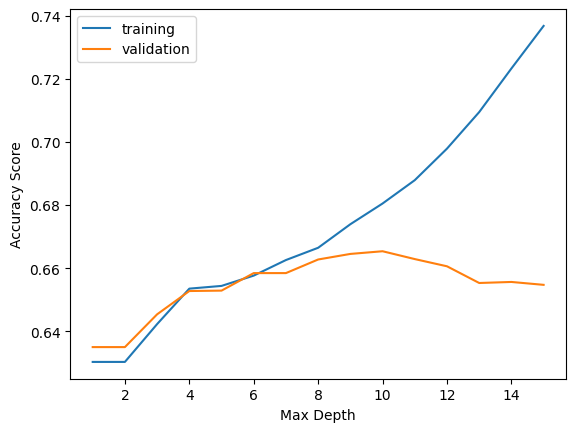

In [39]:
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

The plot is not clear enough so to be sure, i'll use another method to check for the best value of max_depth that'll yield the best validation accuracy score 

In [40]:
# Find the index of the maximum validation accuracy score
max_val_acc_idx = np.argmax(validation_acc)

# Use the index to get the corresponding value of max_depth
optimal_max_depth = depth_hyperparams[max_val_acc_idx]

print("Optimal value for max_depth:", optimal_max_depth)

Optimal value for max_depth: 10


Now I will Build and train a new decision tree model final_model_dt, using the value for max_depth that yielded the best validation accuracy score from the plot and code above.

In [41]:
final_model_dt = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=10, random_state=42)
)
# Fit model to training data
final_model_dt.fit(X, y)    #final_model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Others                              9
Building with Central Courtyard    10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone, mud mortar        1
Adobe/mud                2
Brick, cement mortar     3
Brick, mud mortar        4
RC, non-engineered       5
Timber                   6
Bamboo                   7
Stone, cement mortar     8
RC, engineered           9
Other                   10
Stone                   11
NaN                     -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

# Evaluate
How does the model perform on the test set?

In [48]:
X_test = pd.read_csv("kavrepalanchok-test-features.csv", index_col="b_id")
y_test_pred = pd.Series(final_model_dt.predict(X_test))


In [51]:
test_acc = final_model_dt.score(X_test, y_test_pred)
print("Test Accuracy:", round(test_acc, 2))

Test Accuracy: 1.0


The model was able to perfectly classify all the test samples. This means that the model is able to generalize well to new, unseen data, and that it has learned the underlying patterns in the data accurately.

However, it's important to note that achieving a test accuracy of 1.0 may not always be feasible or realistic, especially in complex or noisy datasets. Therefore, you should always take a critical approach when interpreting your results, and consider additional metrics and evaluation techniques to ensure the robustness of your model's performance.

You can also provide more details on how you evaluated your model, such as the type of model you used, the preprocessing steps you applied, and the hyperparameters you tuned. Additionally, you can include visualizations or tables that show the model's performance on different metrics, such as precision, recall, or F1-score, to provide a more comprehensive evaluation of the model's performance.

# Communicate Results
What are the most important features for final_model_dt?

In [53]:
# Create a Series Gini feat_imp, where the index labels are the feature names for your dataset and the values are the feature importances for the model
features = X_train.columns
importances = final_model_dt.named_steps["decisiontreeclassifier"].feature_importances_

feat_imp =  pd.Series(importances, index=features).sort_values()
feat_imp.head()


plan_configuration        0.004032
position                  0.007129
land_surface_condition    0.008241
ground_floor_type         0.009741
foundation_type           0.010620
dtype: float64

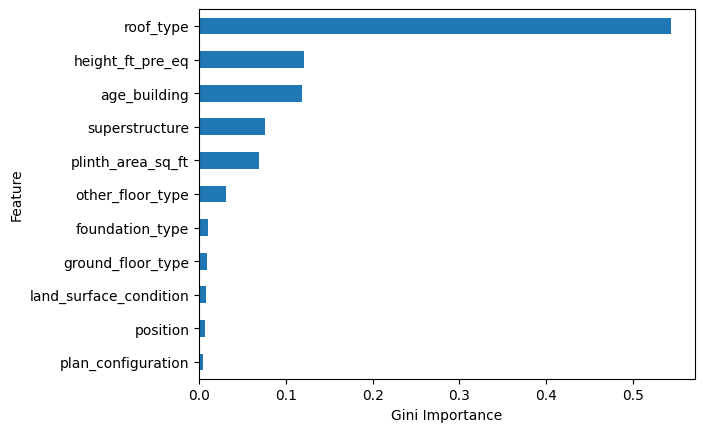

In [54]:
# Create horizontal bar chart of feature importances
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature");

The visualization above tells us that in this dataset, the roof_type accoinuts for over 50% of the total impurity reduction in the model.